In [ ]:
import os
import time
import itertools
import math
import random
import json

import numpy as np

import torch
import torch.nn as nn
import pandas as pd
from typing import Optional, Tuple
from torch.utils.data import Dataset
from  torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
filepath='/content/drive/MyDrive/Tesina_DACLS/dataset/refit/'
h_num='5'
filename='H'+h_num+'_t.csv'
fpath2='/content/drive/MyDrive/Tesina_DACLS/dataset/uk_dale/ukdale/house_2/'
fname2='H2_ukd.npy'
#fname2='data_tot.npy'
app_order=['Unix','Aggregate','WM','DW','KE','FR','MI']
step_size=75
num_appl=5

In [ ]:
# definisci nuovo decoder
class myDecoder(nn.Module):
  def __init__(
      self,
      in_channels,
      out_channels,
      kernel_size,
      stride,
      padding,
      h,
      ):
    # N: dimensione rappresentazione encoder/decoder
    # h: numero di head
        super(myDecoder, self).__init__()
        #self.layer1=nn.MultiheadAttention(embed_dim=512,num_heads=2,batch_first=True)
        #self.layer1=BertSelfAttention(config)
        self.layer2=nn.ConvTranspose1d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=True,
            )
  def forward(self, x):
        #out,_ = self.layer1(x,x,x)
        out=torch.movedim(x,1,2)
        out = self.layer2(out)
        return out

In [ ]:
class ConvBlock(torch.nn.Module):
    """1D Convolutional block.

    Args:
        io_channels (int): The number of input/output channels, <B, Sc>
        hidden_channels (int): The number of channels in the internal layers, <H>.
        kernel_size (int): The convolution kernel size of the middle layer, <P>.
        padding (int): Padding value of the convolution in the middle layer.
        dilation (int, optional): Dilation value of the convolution in the middle layer.
        no_redisual (bool, optional): Disable residual block/output.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.
    """

    def __init__(
        self,
        io_channels: int,
        hidden_channels: int,
        kernel_size: int,
        padding: int,
        dilation: int = 1,
    ):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=io_channels, out_channels=hidden_channels, kernel_size=1),
            nn.PReLU(),
            nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
            nn.Conv1d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=kernel_size,
                padding=padding,
                dilation=dilation,
                groups=hidden_channels,
            ),
            nn.PReLU(),
            nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
            nn.Conv1d(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1),
            nn.Dropout(0.2),
        )


    def forward(self, input: torch.Tensor) -> Tuple[Optional[torch.Tensor], torch.Tensor]:
        feature = self.conv_layers(input)
        return feature


class MaskGenerator(torch.nn.Module):
    """TCN (Temporal Convolution Network) Separation Module

    Generates masks for separation.

    Args:
        input_dim (int): Input feature dimension, <N>.
        num_sources (int): The number of sources to separate.
        kernel_size (int): The convolution kernel size of conv blocks, <P>.
        num_featrs (int): Input/output feature dimenstion of conv blocks, <B, Sc>.
        num_hidden (int): Intermediate feature dimention of conv blocks, <H>
        num_layers (int): The number of conv blocks in one stack, <X>.
        num_stacks (int): The number of conv block stacks, <R>.
        msk_activate (str): The activation function of the mask output.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.
    """

    def __init__(
        self,
        input_dim: int,
        num_sources: int,
        kernel_size: int,
        num_feats: int,
        num_hidden: int,
        num_layers: int,
        num_stacks: int,
        msk_activate: str,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.num_sources = num_sources

        self.input_conv = torch.nn.Conv1d(in_channels=input_dim, out_channels=num_feats, kernel_size=1)

        self.receptive_field = 0
        self.conv_layers = torch.nn.ModuleList([])
        for s in range(num_stacks):
            for l in range(num_layers):
                multi = 2**l
                self.conv_layers.append(
                    ConvBlock(
                        io_channels=num_feats,
                        hidden_channels=num_hidden,
                        kernel_size=kernel_size,
                        dilation=multi,
                        padding=3*multi,########################################################################
                    )
                )
                self.receptive_field += kernel_size if s == 0 and l == 0 else (kernel_size - 1) * multi
        #self.output_prelu = torch.nn.PReLU()
        self.output_conv = torch.nn.Conv1d(
            in_channels=num_feats,
            out_channels=input_dim * num_sources,
            kernel_size=1,
        )
        if msk_activate == "sigmoid":
            self.mask_activate = torch.nn.Sigmoid()
        elif msk_activate == "relu":
            self.mask_activate = torch.nn.ReLU()
        else:
            raise ValueError(f"Unsupported activation {msk_activate}")

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Generate separation mask.

        Args:
            input (torch.Tensor): 3D Tensor with shape [batch, features, frames]

        Returns:
            Tensor: shape [batch, num_sources, features, frames]
        """
        batch_size = input.shape[0]
        feats = self.input_conv(input)
        for layer in self.conv_layers:
            residual = layer(feats)
            feats = feats + residual
        output = self.output_conv(residual)
        output = self.mask_activate(output)
        return output.view(batch_size, self.num_sources, self.input_dim, -1)


class ConvTasNet(torch.nn.Module):
    """Conv-TasNet architecture introduced in
    *Conv-TasNet: Surpassing Ideal Time–Frequency Magnitude Masking for Speech Separation*
    :cite:`Luo_2019`.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.

    See Also:
        * :class:`torchaudio.pipelines.SourceSeparationBundle`: Source separation pipeline with pre-trained models.

    Args:
        num_sources (int, optional): The number of sources to split.
        enc_kernel_size (int, optional): The convolution kernel size of the encoder/decoder, <L>.
        enc_num_feats (int, optional): The feature dimensions passed to mask generator, <N>.
        msk_kernel_size (int, optional): The convolution kernel size of the mask generator, <P>.
        msk_num_feats (int, optional): The input/output feature dimension of conv block in the mask generator, <B, Sc>.
        msk_num_hidden_feats (int, optional): The internal feature dimension of conv block of the mask generator, <H>.
        msk_num_layers (int, optional): The number of layers in one conv block of the mask generator, <X>.
        msk_num_stacks (int, optional): The numbr of conv blocks of the mask generator, <R>.
        msk_activate (str, optional): The activation function of the mask output (Default: ``sigmoid``).
    """

    def __init__(
        self,
        num_sources: int = 2,
        # encoder/decoder parameters
        enc_kernel_size: int = 16,
        enc_num_feats: int = 512,
        # mask generator parameters
        msk_kernel_size: int = 3,
        msk_num_feats: int = 128,
        msk_num_hidden_feats: int = 512,
        msk_num_layers: int = 8,
        msk_num_stacks: int = 3,
        msk_activate: str = "sigmoid",
    ):
        super().__init__()

        self.num_sources = num_sources
        self.enc_num_feats = enc_num_feats
        self.enc_kernel_size = enc_kernel_size
        self.enc_stride = enc_kernel_size // 2

        self.encoder = torch.nn.Conv1d(
            in_channels=1,
            out_channels=enc_num_feats,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            bias=True,
        )
        self.layer1=torch.nn.ReLU()
        self.mask_generator = MaskGenerator(
            input_dim=enc_num_feats,
            num_sources=num_sources,
            kernel_size=msk_kernel_size,
            num_feats=msk_num_feats,
            num_hidden=msk_num_hidden_feats,
            num_layers=msk_num_layers,
            num_stacks=msk_num_stacks,
            msk_activate=msk_activate,
        )
        self.decoder = myDecoder(
            in_channels=enc_num_feats,
            out_channels=1,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            h=2,
        )

    def _align_num_frames_with_strides(self, input: torch.Tensor) -> Tuple[torch.Tensor, int]:
        """Pad input Tensor so that the end of the input tensor corresponds with

        1. (if kernel size is odd) the center of the last convolution kernel
        or 2. (if kernel size is even) the end of the first half of the last convolution kernel

        Assumption:
            The resulting Tensor will be padded with the size of stride (== kernel_width // 2)
            on the both ends in Conv1D

        |<--- k_1 --->|
        |      |            |<-- k_n-1 -->|
        |      |                  |  |<--- k_n --->|
        |      |                  |         |      |
        |      |                  |         |      |
        |      v                  v         v      |
        |<---->|<--- input signal --->|<--->|<---->|
         stride                         PAD  stride

        Args:
            input (torch.Tensor): 3D Tensor with shape (batch_size, channels==1, frames)

        Returns:
            Tensor: Padded Tensor
            int: Number of paddings performed
        """
        batch_size, num_channels, num_frames = input.shape
        is_odd = self.enc_kernel_size % 2
        num_strides = (num_frames - is_odd) // self.enc_stride
        num_remainings = num_frames - (is_odd + num_strides * self.enc_stride)
        if num_remainings == 0:
            return input, 0

        num_paddings = self.enc_stride - num_remainings
        pad = torch.zeros(
            batch_size,
            num_channels,
            num_paddings,
            dtype=input.dtype,
            device=input.device,
        )
        return torch.cat([input, pad], 2), num_paddings

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Perform source separation. Generate audio source waveforms.

        Args:
            input (torch.Tensor): 3D Tensor with shape [batch, channel==1, frames]

        Returns:
            Tensor: 3D Tensor with shape [batch, channel==num_sources, frames]
        """
        if input.ndim != 3 or input.shape[1] != 1:
            raise ValueError(f"Expected 3D tensor (batch, channel==1, frames). Found: {input.shape}")

        # B: batch size
        # L: input frame length
        # L': padded input frame length
        # F: feature dimension
        # M: feature frame length
        # S: number of sources

        padded, num_pads = self._align_num_frames_with_strides(input)  # B, 1, L'
        batch_size, num_padded_frames = padded.shape[0], padded.shape[2]
        feats = self.encoder(padded)  # B, F, M
        #feats=self.layer1(feats)
        masked = self.mask_generator(feats) * feats.unsqueeze(1)  # B, S, F, M
        masked = masked.view(batch_size * self.num_sources,-1,self.enc_num_feats)  # B*S, F,M
        decoded = self.decoder(masked)  # B*S, 1, L'
        #print(decoded.size())
        output = decoded.view(batch_size, self.num_sources, num_padded_frames)  # B, S, L'
        if num_pads > 0:
            output = output[..., :-num_pads]  # B, S, L
        return output



def conv_tasnet_base(num_sources: int = 2) -> ConvTasNet:
    r"""Builds non-causal version of :class:`~torchaudio.models.ConvTasNet`.

    The parameter settings follow the ones with the highest Si-SNR metirc score in the paper,
    except the mask activation function is changed from "sigmoid" to "relu" for performance improvement.

    Args:
        num_sources (int, optional): Number of sources in the output.
            (Default: 2)
    Returns:
        ConvTasNet:
            ConvTasNet model.
    """
    return ConvTasNet(
        num_sources=num_sources,
        enc_kernel_size=16,
        enc_num_feats=512,
        msk_kernel_size=3,
        msk_num_feats=128,
        msk_num_hidden_feats=512,
        msk_num_layers=8,
        msk_num_stacks=3,
        msk_activate="relu",
    )

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model= ConvTasNet(num_sources=num_appl,enc_kernel_size=10,enc_num_feats=768,msk_num_feats=256,msk_num_hidden_feats=512,msk_kernel_size=7,msk_num_layers=4,msk_num_stacks=4)

model=model.to(device)
#### Stampa numero parametri allenabili
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"The network has {params} trainable parameters")

The network has 5504801 trainable parameters


In [ ]:
param_path='/content/drive/MyDrive/Tesina_DACLS/best_param.pth'
save_state=torch.load(param_path)
print(save_state['epoch'])
model.load_state_dict(save_state['model_state_dict'])

23


<All keys matched successfully>

In [ ]:
class REFITdataset(Dataset): #
    def __init__(self, path,filename, len_win):
        self.win=len_win
        #self.path=path
        #self.files=filename
        self.data=pd.read_csv(path+filename,usecols=[1,2,3,4,5,6])
        self.data=torch.tensor(self.data[['Aggregate','WM','DW','KE','FR','MI']].values , dtype=torch.float32)
        mean_vect=torch.tensor([618,10,85,6,60,2])
        var_vect=torch.tensor([847,122,380,123,58,48])
        #mean_vect=torch.tensor([0,0,0,0,0,0])
        #var_vect=torch.tensor([68093,1,1,1,1,1])
        self.data=torch.div((torch.sub(self.data,mean_vect)),var_vect)
        self.data=torch.transpose(self.data,0,1)

    def __getitem__(self, index):
        x=self.data[0,100*index:100*index+self.win].unsqueeze(0)
        y=self.data[1:6,100*index:100*index+self.win] #prende fino a :6-1
        return x,y

    def __len__(self): #ritorna gli indici che non vanno out-of-bound per sliding windows e step size
        l=self.data.size(1)
        l=math.floor((l-self.win)/100)
        l=256*(math.floor(l/256)) # deve essere inoltre divisibile per num batch
        #l=768
        return l

In [ ]:
class UKDALEdataset(Dataset):
    def __init__(self, path,filename, len_win,step_size):
        self.win=len_win
        self.step=step_size
        #self.path=path
        #self.files=filename
        self.data=np.load(path+filename)
        print(self.data.shape[0])
        self.data=torch.from_numpy(self.data)
        mean_vect=torch.tensor([527,54,55,27,50,17])
        var_vect=torch.tensor([600,281,335,250,54,119])
        #mean_vect=torch.tensor([0,0,0,0,0,0])
        #var_vect=torch.tensor([68093,1,1,1,1,1])
        self.data=torch.div((torch.sub(self.data,mean_vect)),var_vect)
        self.data=torch.transpose(self.data,0,1).float()

    def __getitem__(self, index):
        x=self.data[0,self.step*index:self.step*index+self.win].unsqueeze(0)
        y=self.data[1:6,self.step*index:self.step*index+self.win] #prende fino a :6-1
        return x,y

    def __len__(self): #ritorna gli indici che non vanno out-of-bound per sliding windows e step size
        l=self.data.size(1)
        l=math.floor((l-self.win)/self.step)
        l=256*(math.floor(l/256)) # deve essere inoltre divisibile per num batch
        #l=768
        return l

In [ ]:
#with open('/content/drive/MyDrive/Tesina_DACLS/idx_subset/h2_ukdale_idx_subset_val.json', 'r') as f:
with open('/content/drive/MyDrive/Tesina_DACLS/idx_subset/h5_idx_subset_val.json', 'r') as f:
     val_idx=(json.load(f))
while len(val_idx)%256!=0:
    del val_idx[-1]

In [ ]:
data=REFITdataset(filepath,filename,600)
#data=UKDALEdataset(fpath2,fname2,600,75)
#val_dataload=torch.utils.data.DataLoader(data, batch_size=256, num_workers=0, pin_memory=True)
val_dataload=torch.utils.data.DataLoader(data, batch_size=256, num_workers=0, pin_memory=True, sampler=SubsetRandomSampler(val_idx))

In [ ]:
#print(data[4])
print(len(data))


74240


In [ ]:
def MAE(ye,ygt): #Entra BATCHxAPPLxNT, esce 1xAPPLx1
  temp=ye-ygt
  temp= torch.abs(temp)
  MAE=torch.sum(temp,2)/600
  MAE=torch.sum(MAE,0)/256
  return MAE

In [ ]:
def SAE(ye,ygt):
  temp_e=torch.sum(ye,2)
  temp_gt=torch.sum(ygt,2)
  temp_e=torch.sum(temp_e,0) #energia
  temp_gt=torch.sum(temp_gt,0)
  SAE=torch.zeros(5,device='cuda',dtype=torch.float32)
  for i in range(5):
    SAE[i]=(torch.abs(temp_e[i]-temp_gt[i]))
  return SAE,temp_gt

In [ ]:
def SAEd(ye,ygt,Td):
  ye=ye[:,:,0:Td]
  ygt=ygt[:,:,0:Td]
  temp_e=torch.sum(ye,2) #energia
  temp_gt=torch.sum(ygt,2)
  SAE=torch.zeros(256,5,device='cuda',dtype=torch.float32)
  for i in range(5):
    SAE[:,i]=(torch.abs(temp_e[:,i]-temp_gt[:,i]))/Td
  SAE=torch.sum(SAE,0)/256
  return SAE


In [ ]:
relu=nn.ReLU()
mean_vect=torch.tensor([618,10,85,6,60,2])
var_vect=torch.tensor([847,122,380,123,58,48])
#mean_vect=torch.tensor([527,54,55,27,50,17])
#var_vect=torch.tensor([600,281,335,250,54,119])
#mean_vect=torch.tensor([0,0,0,0,0,0])
#var_vect=torch.tensor([68093,1,1,1,1,1])
num_MAE=torch.zeros(5, dtype=torch.float32, device='cuda')
num_SAE=num_MAE
en_tot=num_MAE
en_tot_t=num_MAE
num_SAE_t=num_MAE
num_SAE2=num_MAE
c=0
labels_cpu=torch.zeros(len(val_dataload)*256,5,600)
out_cpu=torch.zeros(len(val_dataload)*256,5,600)
data_cpu=torch.zeros(len(val_dataload)*256,1,600)
model.eval()
with torch.no_grad():
  for data, labels in val_dataload:
    data=data.cuda()
    labels=labels.cuda()
    out=model(data)
    for i in range(1,6):
      labels[:,i-1,:]=labels[:,i-1,:]*var_vect[i]+mean_vect[i]
      out[:,i-1,:]=(out[:,i-1,:]*var_vect[i]+mean_vect[i])
      #out[:,i-1,:]=relu(out[:,i-1,:]*var_vect[i]+mean_vect[i])
    data_cpu[256*c:256*(c+1),:]=data*var_vect[0]+mean_vect[0]
    labels_cpu[256*c:256*(c+1),:,:]=labels
    out_cpu[256*c:256*(c+1),:,:]=out
    c=c+1
    num_MAE=num_MAE+MAE(out,labels)
    num_SAE_t,en_tot_t=SAE(out,labels)
    num_SAE2=num_SAE2+SAEd(out,labels,450)
    num_SAE=num_SAE+num_SAE_t
    en_tot=en_tot+en_tot_t
  num_MAE=num_MAE/len(val_dataload)
  num_SAE=num_SAE/en_tot
  num_SAE2=num_SAE2/len(val_dataload)

In [ ]:
labels_cpu=labels_cpu.cpu()
out_cpu=out_cpu.cpu()
data_cpu=data_cpu.cpu()

In [ ]:
avg_MAE=torch.mean(num_MAE)
avg_SAE=torch.mean(num_SAE)
avg_SAE2=torch.mean(num_SAE2)

In [ ]:
b_list=[]
min_list=[]
for i in range(0,len(val_dataload)*256):
  if torch.max(labels_cpu[i,1,:])>800:
    if torch.sum(labels_cpu[i,2,:])>63000:
      b_list.append(i)
print(len(b_list))

k=-1


11


45


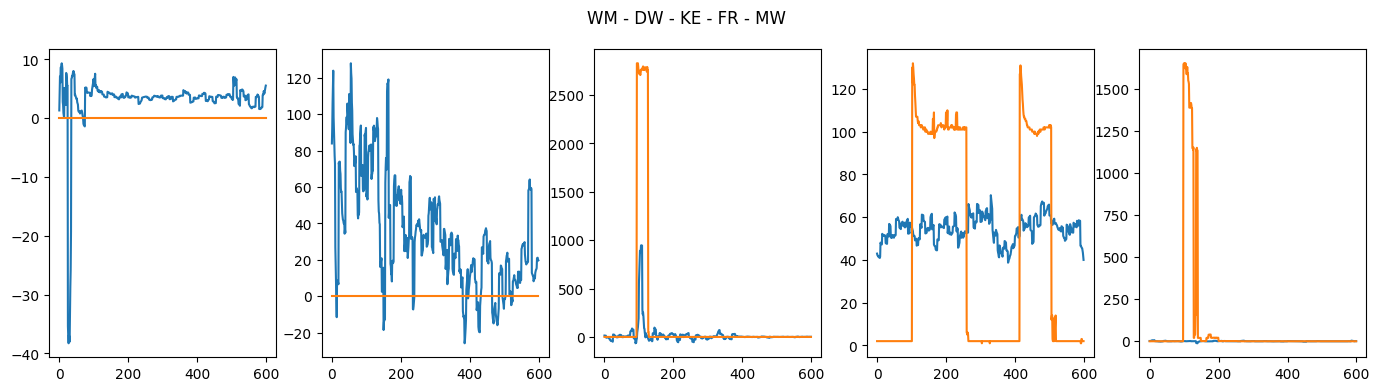

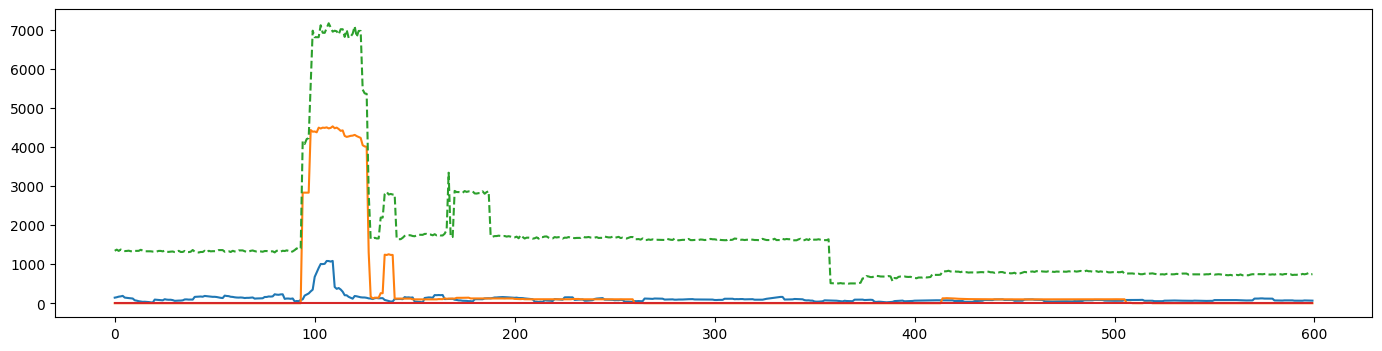

In [ ]:
b=45
print(b)
#plt.figure()
#plt.plot(in1[b,0,0:],'--')
#plt.figure()
plt.rcParams['figure.figsize'] = [17, 4]
#appl=4
#plt.plot(out_cpu[b,appl,0:])
#plt.plot(labels_cpu[b,appl,0:])
fig, (a1, a2, a3, a4, a5) = plt.subplots(1, 5)
fig.suptitle('WM - DW - KE - FR - MW')
a1.plot(out_cpu[b,0,0:]); a1.plot(labels_cpu[b,0,0:])
a2.plot(out_cpu[b,1,0:]); a2.plot(labels_cpu[b,1,0:])
a3.plot(out_cpu[b,2,0:]); a3.plot(labels_cpu[b,2,0:])
a4.plot(out_cpu[b,3,0:]); a4.plot(labels_cpu[b,3,0:])
a5.plot(out_cpu[b,4,0:]); a5.plot(labels_cpu[b,4,0:])

plt.figure()
plt.plot(out_cpu[b,0,0:]+out_cpu[b,1,0:]+out_cpu[b,2,0:]+out_cpu[b,3,0:]+out_cpu[b,4,0:])
plt.plot(labels_cpu[b,0,0:]+labels_cpu[b,1,0:]+labels_cpu[b,2,0:]+labels_cpu[b,3,0:]+labels_cpu[b,4,0:])
plt.plot(data_cpu[b,0,:],'--')
plt.plot(torch.zeros(600))



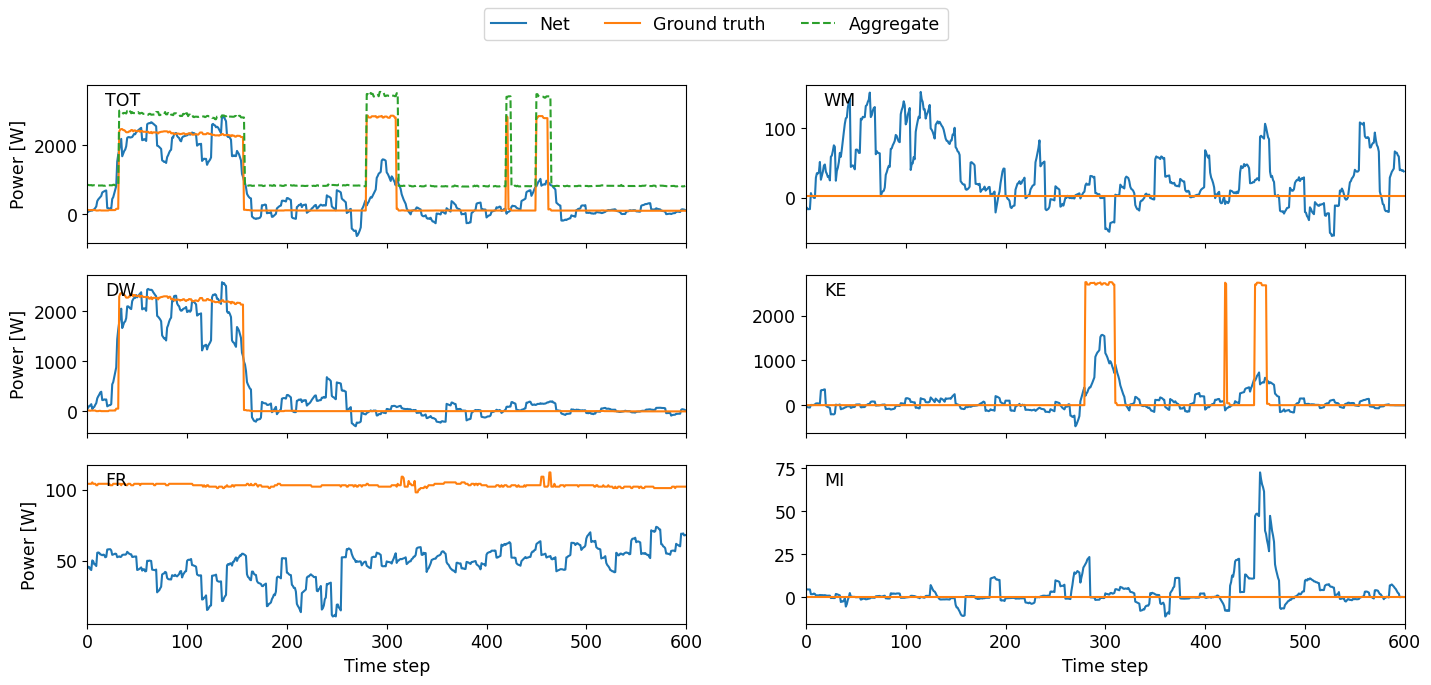

In [ ]:
b=b_list[k]
plt.rcParams['figure.figsize'] = [17, 7]
plt.rcParams.update({'font.size': 12.5})

fig, ((a1, a2),(a3, a4), (a5, a6)) = plt.subplots(3, 2, sharex=True)

#fig.suptitle('WM - DW - KE - FR - MW')
a1.plot(out_cpu[b,0,0:]+out_cpu[b,1,0:]+out_cpu[b,2,0:]+out_cpu[b,3,0:]+out_cpu[b,4,0:])
a1.plot(labels_cpu[b,0,0:]+labels_cpu[b,1,0:]+labels_cpu[b,2,0:]+labels_cpu[b,3,0:]+labels_cpu[b,4,0:])
a1.plot(data_cpu[b,0,:],'--')
a1.text(0.03, 0.87,'TOT', transform=a1.transAxes)
fig.legend(['Net','Ground truth','Aggregate'],loc = 'upper center', ncol=3)


a2.plot(out_cpu[b,0,0:]); a2.plot(labels_cpu[b,0,0:])
a3.plot(out_cpu[b,1,0:]); a3.plot(labels_cpu[b,1,0:])
a4.plot(out_cpu[b,2,0:]); a4.plot(labels_cpu[b,2,0:])
a5.plot(out_cpu[b,3,0:]); a5.plot(labels_cpu[b,3,0:])
a6.plot(out_cpu[b,4,0:]); a6.plot(labels_cpu[b,4,0:])

a1.set(ylabel='Power [W]')
a3.set(ylabel='Power [W]')
a5.set(xlabel='Time step', ylabel='Power [W]')
a6.set(xlabel='Time step')
a2.text(0.03, 0.87,'WM', transform=a2.transAxes)
a3.text(0.03, 0.87,'DW', transform=a3.transAxes)
a4.text(0.03, 0.87,'KE', transform=a4.transAxes)
a5.text(0.03, 0.87,'FR', transform=a5.transAxes)
a6.text(0.03, 0.87,'MI', transform=a6.transAxes)
plt.xlim([0, 600])
k=k-1


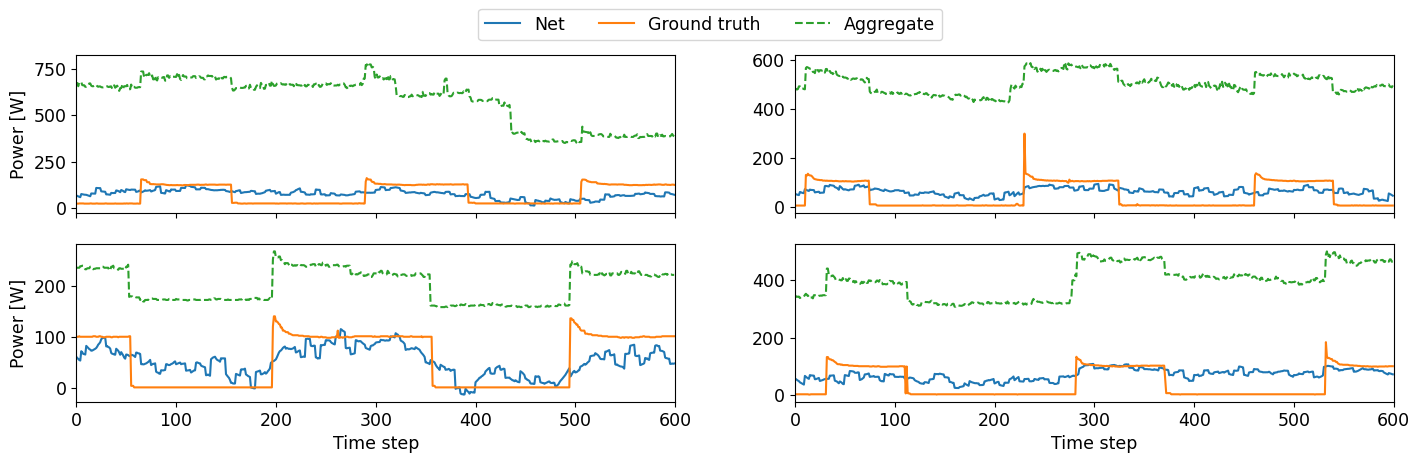

In [ ]:
b=28722
b1=32428
b2=345
b3=31239
plt.rcParams['figure.figsize'] = [17, 4.5]
plt.rcParams.update({'font.size': 12.5})

fig, ((a1, a2),(a3, a4)) = plt.subplots(2, 2, sharex=True)

#fig.suptitle('WM - DW - KE - FR - MW')
a1.plot(out_cpu[b,0,0:]+out_cpu[b,1,0:]+out_cpu[b,2,0:]+out_cpu[b,3,0:]+out_cpu[b,4,0:])
a1.plot(labels_cpu[b,0,0:]+labels_cpu[b,1,0:]+labels_cpu[b,2,0:]+labels_cpu[b,3,0:]+labels_cpu[b,4,0:])
a1.plot(data_cpu[b,0,:],'--')
fig.legend(['Net','Ground truth','Aggregate'],loc = 'upper center', ncol=3)

a2.plot(out_cpu[b1,0,0:]+out_cpu[b1,1,0:]+out_cpu[b1,2,0:]+out_cpu[b1,3,0:]+out_cpu[b1,4,0:])
a2.plot(labels_cpu[b1,0,0:]+labels_cpu[b1,1,0:]+labels_cpu[b1,2,0:]+labels_cpu[b1,3,0:]+labels_cpu[b1,4,0:])
a2.plot(data_cpu[b1,0,:],'--')
a3.plot(out_cpu[b2,0,0:]+out_cpu[b2,1,0:]+out_cpu[b2,2,0:]+out_cpu[b2,3,0:]+out_cpu[b2,4,0:])
a3.plot(labels_cpu[b2,0,0:]+labels_cpu[b2,1,0:]+labels_cpu[b2,2,0:]+labels_cpu[b2,3,0:]+labels_cpu[b2,4,0:])
a3.plot(data_cpu[b2,0,:],'--')
a4.plot(out_cpu[b3,0,0:]+out_cpu[b3,1,0:]+out_cpu[b3,2,0:]+out_cpu[b3,3,0:]+out_cpu[b3,4,0:])
a4.plot(labels_cpu[b3,0,0:]+labels_cpu[b3,1,0:]+labels_cpu[b3,2,0:]+labels_cpu[b3,3,0:]+labels_cpu[b3,4,0:])
a4.plot(data_cpu[b3,0,:],'--')

a1.set(ylabel='Power [W]')
a3.set(xlabel='Time step', ylabel='Power [W]')
a4.set(xlabel='Time step')
plt.xlim([0, 600])
k=k-1


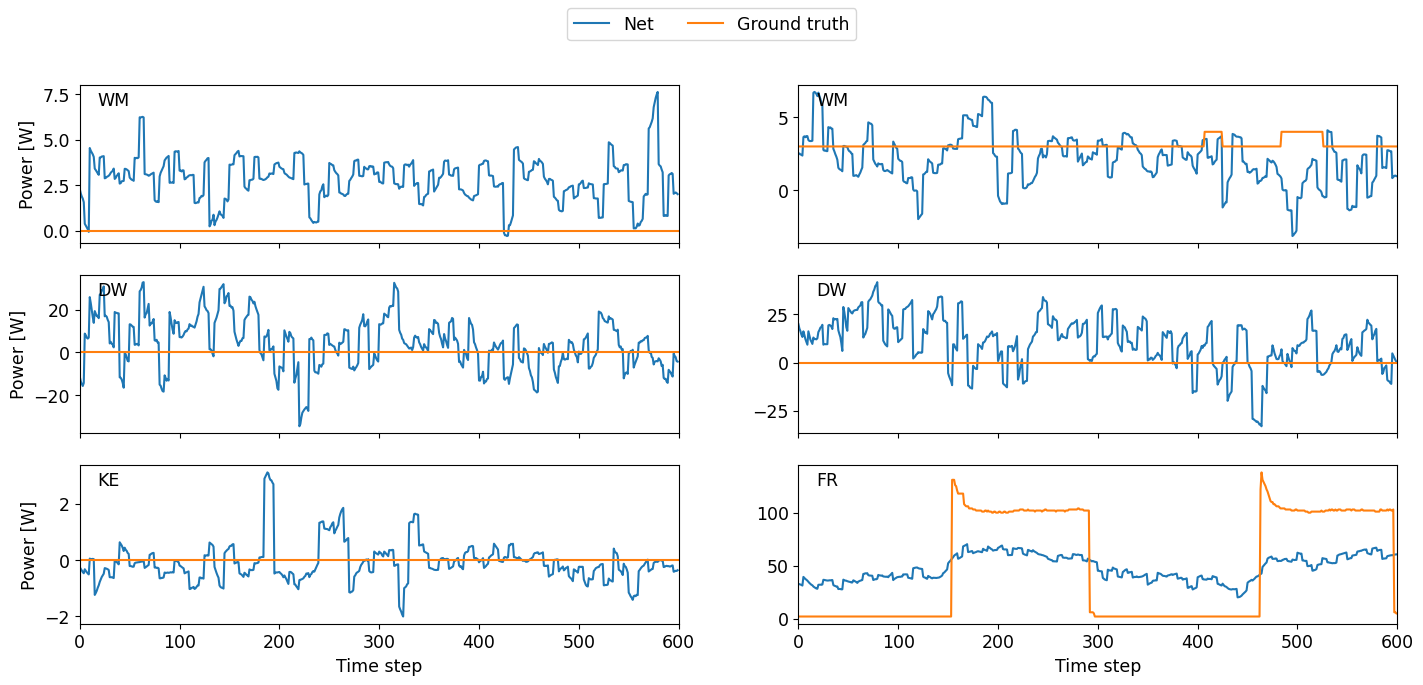

In [ ]:
b=30613
b1=26373
b2=25084
b4=17056
b5=31831
b6=-10
plt.rcParams['figure.figsize'] = [17, 7]
plt.rcParams.update({'font.size': 12.5})

fig, ((a1, a2),(a3, a4), (a5, a6)) = plt.subplots(3, 2, sharex=True)

#fig.suptitle('WM - DW - KE - FR - MW')
a1.plot(out_cpu[b,0,0:]); a1.plot(labels_cpu[b,0,0:])
a1.text(0.03, 0.87,'WM', transform=a1.transAxes)
fig.legend(['Net','Ground truth'],loc = 'upper center', ncol=3)

a2.plot(out_cpu[b1,0,0:]); a2.plot(labels_cpu[b1,0,0:])
a3.plot(out_cpu[b2,1,0:]); a3.plot(labels_cpu[b2,1,0:])
a4.plot(out_cpu[b4,1,0:]); a4.plot(labels_cpu[b4,1,0:])
a5.plot(out_cpu[b5,2,0:]); a5.plot(labels_cpu[b5,2,0:])
a6.plot(out_cpu[b6,3,0:]); a6.plot(labels_cpu[b6,3,0:])

a1.set(ylabel='Power [W]')
a3.set(ylabel='Power [W]')
a5.set(xlabel='Time step', ylabel='Power [W]')
a6.set(xlabel='Time step')
a2.text(0.03, 0.87,'WM', transform=a2.transAxes)
a3.text(0.03, 0.87,'DW', transform=a3.transAxes)
a4.text(0.03, 0.87,'DW', transform=a4.transAxes)
a5.text(0.03, 0.87,'KE', transform=a5.transAxes)
a6.text(0.03, 0.87,'FR', transform=a6.transAxes)
plt.xlim([0, 600])

k=k-1
